# Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../')))
from db_connection.connection import PostgresConnection
from sklearn.decomposition import PCA
import src.telecom_experience_analysis as tea
from IPython.display import display, HTML



# Add the src directory to the system path


In [2]:
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../src')))
from telecom_experience_analysis import (
    load_data, clean_data, aggregate_per_customer,
    get_top_bottom_frequent, plot_throughput_distribution,
    plot_tcp_retransmission, perform_clustering
)

## Initialize and connect to the PostgreSQL database


In [3]:
db = PostgresConnection()
db.connect()

Connected to PostgreSQL Database!


# Load the data


In [4]:
query = "SELECT * FROM xdr_data;"
df = db.fetch_data(query)
df.head()

c:\Users\habteyes.asfaw\10Accadamy\TellCo-Telecom-User-Analytics\db_connection\connection.py:29: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql_query(query, self.conn)


,Bearer Id,Start,Start ms,End,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Last Location Name,...,Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
0,1.311448e+19,4/4/2019 12:01,770.0,4/25/2019 14:35,662.0,1823652.0,2.082014e+14,3.366496e+10,3.552121e+13,9.16456699548519E+015,...,15854611.0,2501332.0,8198936.0,9656251.0,278082303.0,14344150.0,171744450.0,8814393.0,36749741.0,308879636.0
1,1.311448e+19,4/9/2019 13:04,235.0,4/25/2019 8:15,606.0,1365104.0,2.082019e+14,3.368185e+10,3.579401e+13,L77566A,...,20247395.0,19111729.0,18338413.0,17227132.0,608750074.0,1170709.0,526904238.0,15055145.0,53800391.0,653384965.0
2,1.311448e+19,4/9/2019 17:42,1.0,4/25/2019 11:58,652.0,1361762.0,2.082003e+14,3.376063e+10,3.528151e+13,D42335A,...,19725661.0,14699576.0,17587794.0,6163408.0,229584621.0,395630.0,410692588.0,4215763.0,27883638.0,279807335.0
3,1.311448e+19,4/10/2019 0:31,486.0,4/25/2019 7:36,171.0,1321509.0,2.082014e+14,3.375034e+10,3.535661e+13,T21824A,...,21388122.0,15146643.0,13994646.0,1097942.0,799538153.0,10849722.0,749039933.0,12797283.0,43324218.0,846028530.0
4,1.311448e+19,4/12/2019 20:10,565.0,4/25/2019 10:40,954.0,1089009.0,2.082014e+14,3.369980e+10,3.540701e+13,D88865A,...,15259380.0,18962873.0,17124581.0,415218.0,527707248.0,3529801.0,550709500.0,13910322.0,38542814.0,569138589.0


# Task 3.1: Data Cleaning and Aggregation


In [5]:
df_cleaned = tea.clean_data(df)


c:\Users\habteyes.asfaw\10Accadamy\TellCo-Telecom-User-Analytics\src\telecom_experience_analysis.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(mean_value, inplace=True)


# Aggregate data per customer


In [6]:
df_aggregated = tea.aggregate_per_customer(df_cleaned)
# Display the aggregated data
df_aggregated.head()

,MSISDN/Number,avg_tcp_retransmission,avg_rtt,avg_throughput,Handset Type
0,3.360100e+10,2.080991e+07,46.000000,37.0,Huawei P20 Lite Huawei Nova 3E
1,3.360100e+10,2.080991e+07,30.000000,48.0,Apple iPhone 7 (A1778)
2,3.360100e+10,2.080991e+07,109.795706,48.0,undefined
3,3.360101e+10,1.066000e+03,69.000000,204.0,Apple iPhone 5S (A1457)
4,3.360101e+10,1.507977e+07,57.000000,20197.5,Apple iPhone Se (A1723)


# Task 3.2: Top, Bottom, and Frequent Values


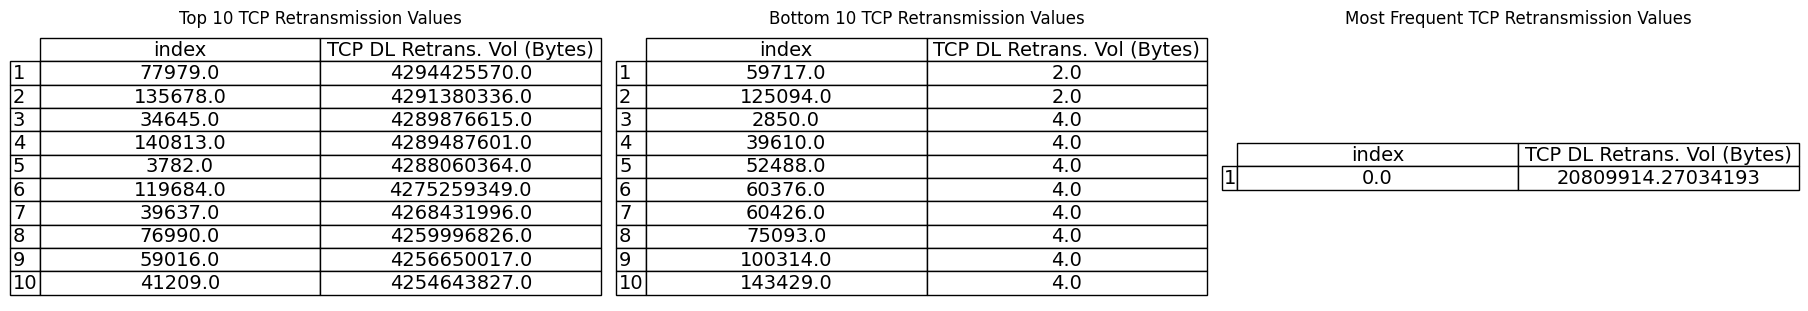

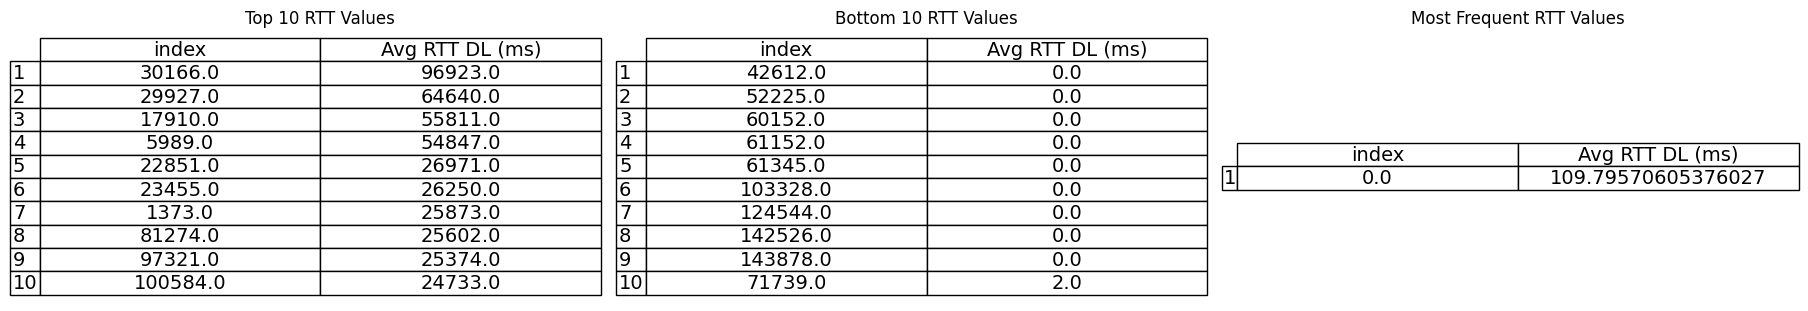

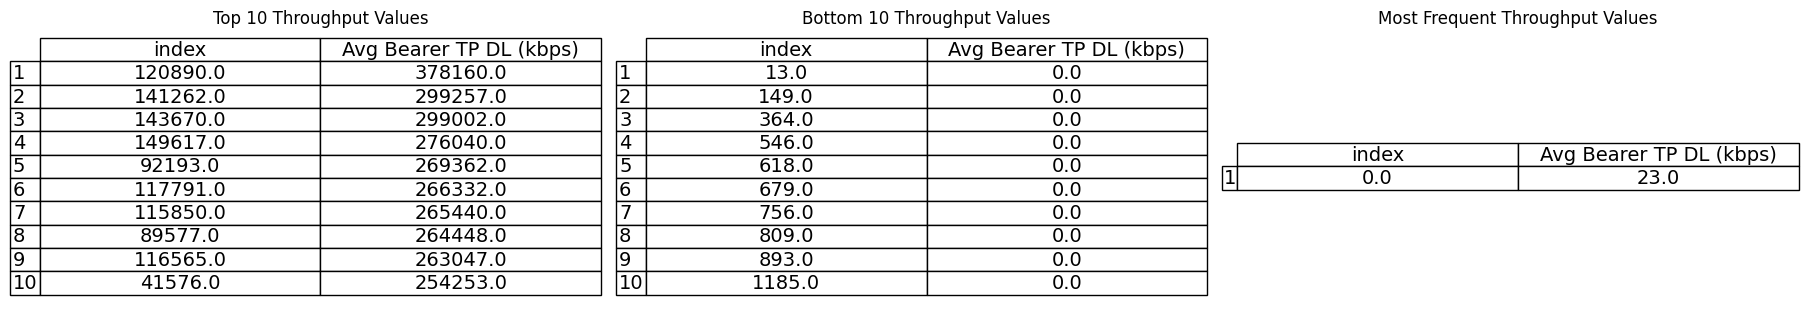

In [7]:
tcp_top, tcp_bottom, tcp_frequent = get_top_bottom_frequent(df_cleaned, 'TCP DL Retrans. Vol (Bytes)')
rtt_top, rtt_bottom, rtt_frequent = get_top_bottom_frequent(df_cleaned, 'Avg RTT DL (ms)')
throughput_top, throughput_bottom, throughput_frequent = get_top_bottom_frequent(df_cleaned, 'Avg Bearer TP DL (kbps)')

# Function to display tables side by side
def display_side_by_side(*dfs, titles):
    fig, axs = plt.subplots(1, len(dfs), figsize=(18, 3), constrained_layout=True)
    for ax, df, title in zip(axs, dfs, titles):
        ax.axis('off')
        table = ax.table(cellText=df.values,
                         colLabels=df.columns,
                         rowLabels=df.index + 1,
                         cellLoc='center',
                         loc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(14)
        table.scale(1.2, 1.2)
        ax.set_title(title)
    plt.show()

# Display tables
display_side_by_side(
    tcp_top,
    tcp_bottom,
    tcp_frequent,
    titles=["Top 10 TCP Retransmission Values", "Bottom 10 TCP Retransmission Values", "Most Frequent TCP Retransmission Values"]
)

display_side_by_side(
    rtt_top,
    rtt_bottom,
    rtt_frequent,
    titles=["Top 10 RTT Values", "Bottom 10 RTT Values", "Most Frequent RTT Values"]
)

display_side_by_side(
    throughput_top,
    throughput_bottom,
    throughput_frequent,
    titles=["Top 10 Throughput Values", "Bottom 10 Throughput Values", "Most Frequent Throughput Values"]
)

## Task 4: Plot throughput distribution and TCP retransmission per handset type




c:\Users\habteyes.asfaw\10Accadamy\TellCo-Telecom-User-Analytics\src\telecom_experience_analysis.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Handset Type', y='avg_throughput', data=df, palette='Blues', legend=False)  # Use legend=False
c:\Users\habteyes.asfaw\10Accadamy\TellCo-Telecom-User-Analytics\src\telecom_experience_analysis.py:63: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(pad=3.5)  # Adjust padding


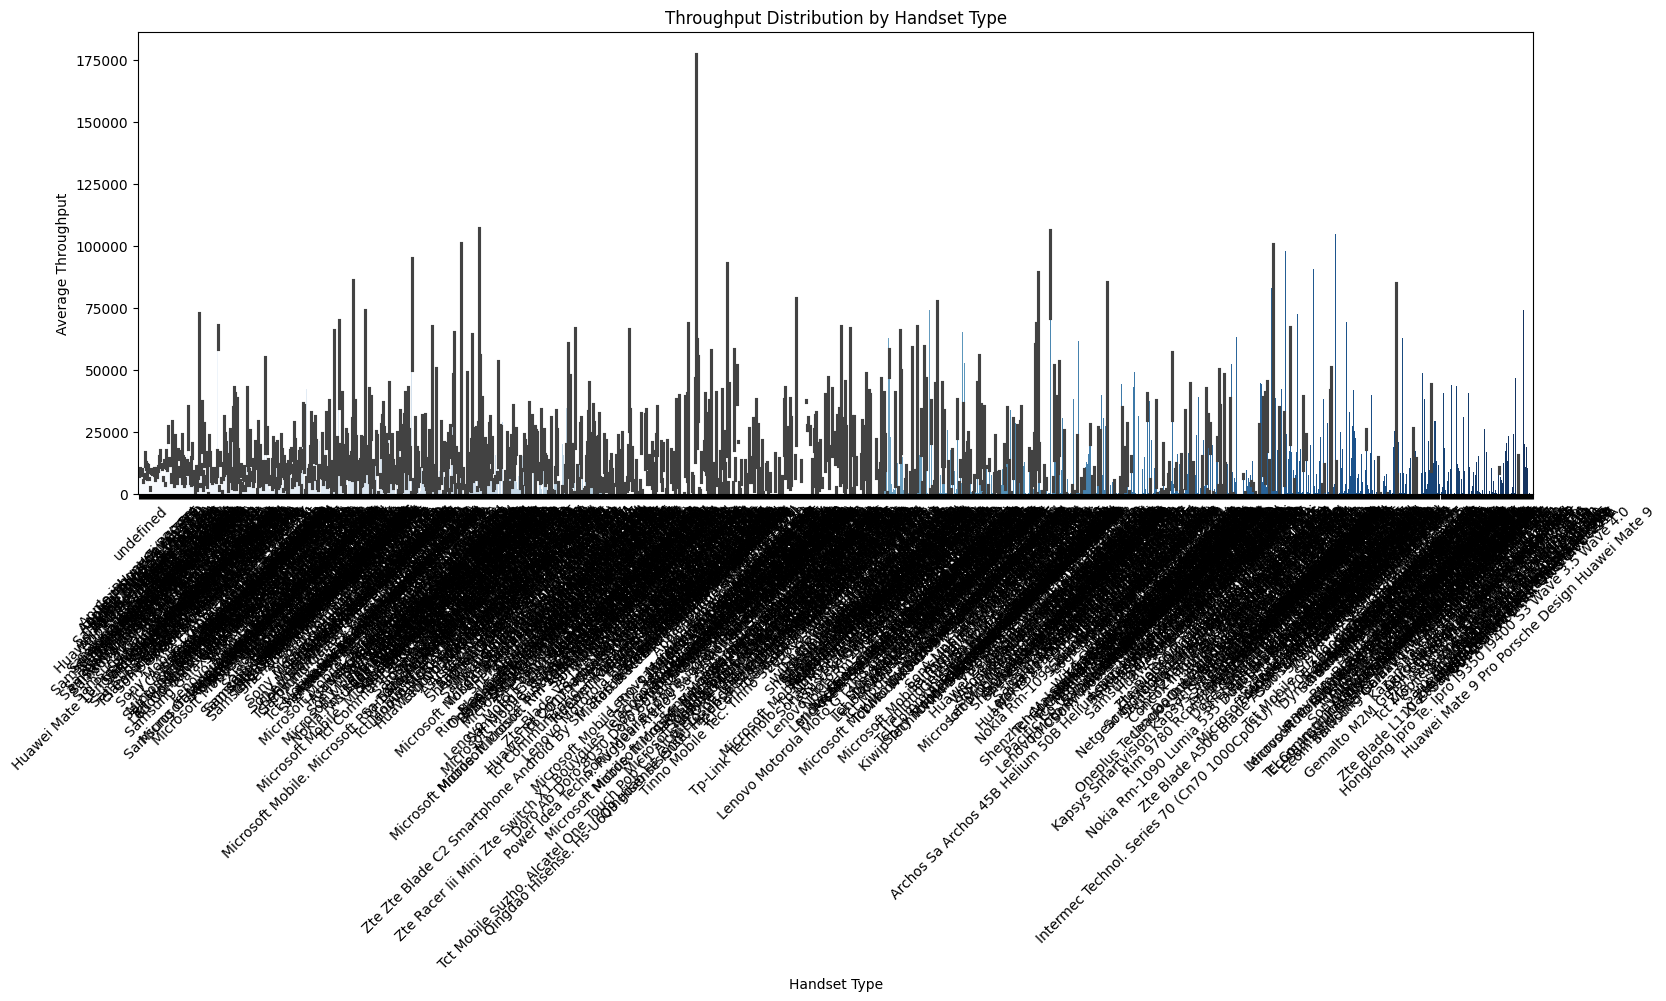

c:\Users\habteyes.asfaw\10Accadamy\TellCo-Telecom-User-Analytics\src\telecom_experience_analysis.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Handset Type', y='avg_tcp_retransmission', data=df, palette='Reds', legend=False)  # Fix palette and hue warning
c:\Users\habteyes.asfaw\10Accadamy\TellCo-Telecom-User-Analytics\src\telecom_experience_analysis.py:73: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(pad=3.5)  # Adjust padding to fit layout


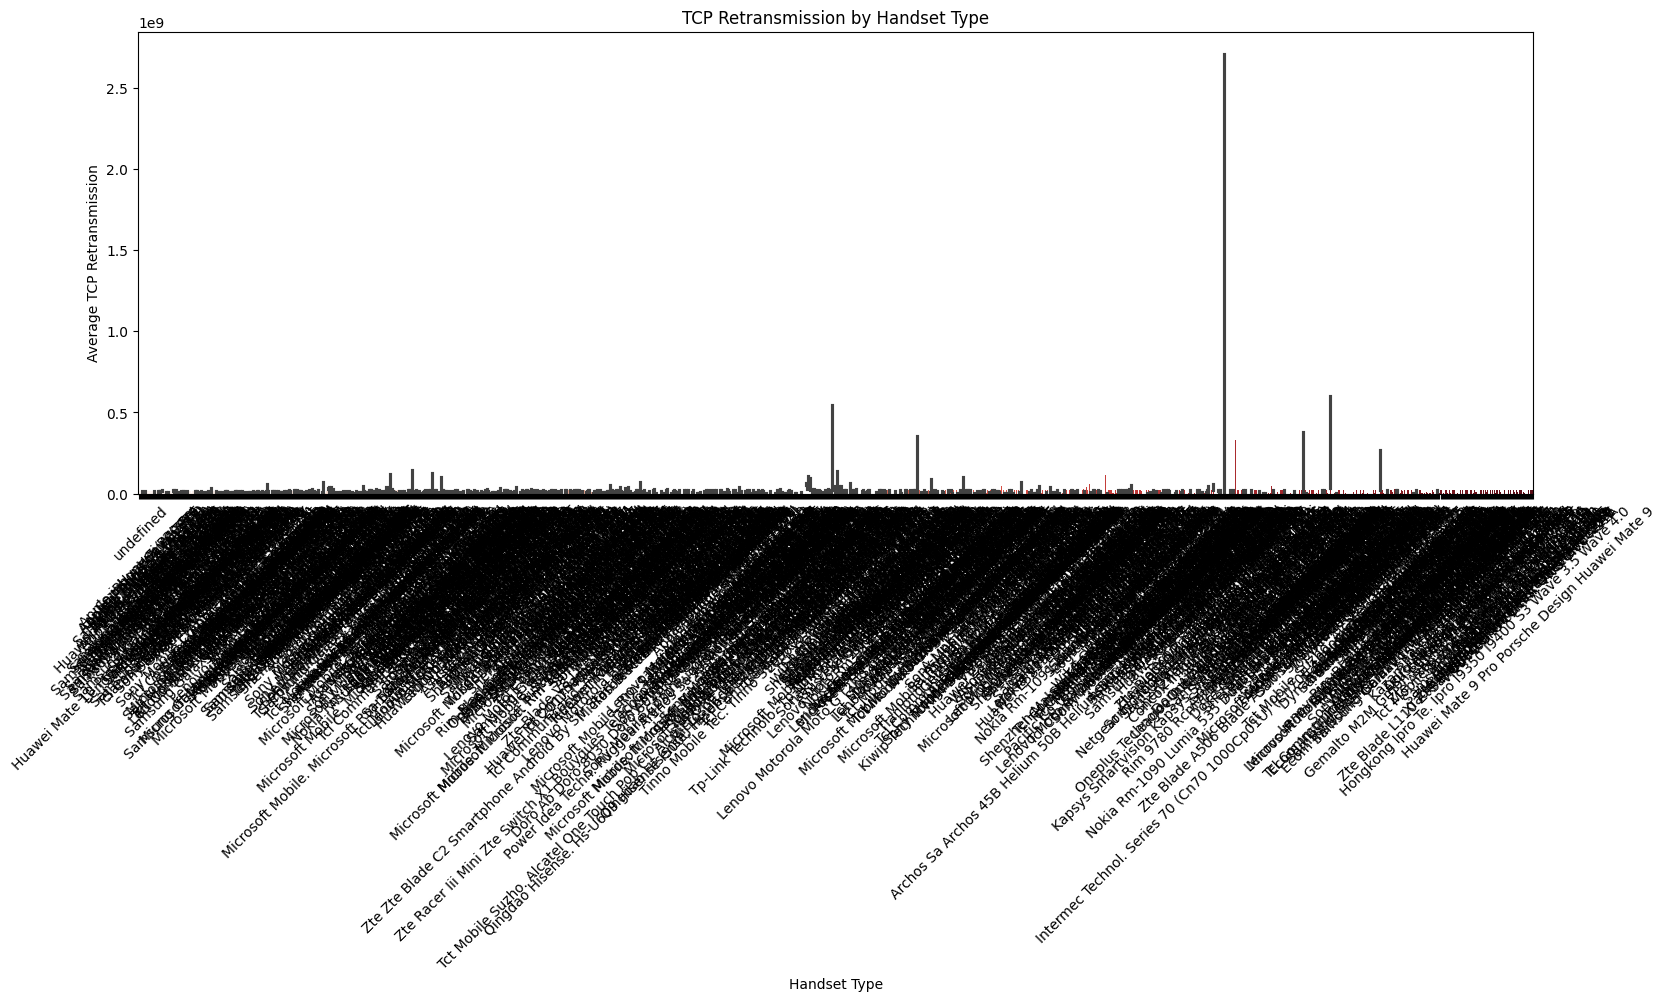

In [8]:

# Plot distributions
plot_throughput_distribution(df_aggregated)
plot_tcp_retransmission(df_aggregated)

# Perform k-means clustering


In [9]:
df_clustered, kmeans = perform_clustering(df_aggregated)
display(df_clustered.head())  # Displaying the first few rows of the clustered data

,MSISDN/Number,avg_tcp_retransmission,avg_rtt,avg_throughput,Handset Type,cluster
0,3.360100e+10,2.080991e+07,46.000000,37.0,Huawei P20 Lite Huawei Nova 3E,1
1,3.360100e+10,2.080991e+07,30.000000,48.0,Apple iPhone 7 (A1778),1
2,3.360100e+10,2.080991e+07,109.795706,48.0,undefined,1
3,3.360101e+10,1.066000e+03,69.000000,204.0,Apple iPhone 5S (A1457),1
4,3.360101e+10,1.507977e+07,57.000000,20197.5,Apple iPhone Se (A1723),1
